In [1]:
# pip install tensorflow==2.15.1 

In [2]:
import os
import tensorflow as tf
import wandb
from wandb.keras import WandbCallback
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, Dense, LSTM, Dropout, TimeDistributed, Bidirectional, MaxPooling1D, Concatenate, GlobalAveragePooling1D, AdditiveAttention, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import AdditiveAttention, MultiHeadAttention
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
url_data = 'https://raw.githubusercontent.com/TeodorRusKvi/Tekstanalyse/main/git_NLP_data/'

# Last inn 'X_train_LSTM' fra en CSV-fil
X_df = pd.read_csv(url_data+'X_tensorflow.csv')
# Konverter hele DataFrame til et NumPy array
X = X_df.to_numpy()

# Last inn 'y_train_LSTM' fra en CSV-fil
y_df = pd.read_csv(url_data+'y_liberal.csv')
# Konverter hele DataFrame til et NumPy array
y = y_df.to_numpy()

# Last inn 'y_train_LSTM' fra en CSV-fil
embeddings_GloVe = pd.read_csv(url_data+'embeddings_glove.csv')
# Konverter hele DataFrame til et NumPy array
embeddings_GloVe = embeddings_GloVe.to_numpy()


# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [24]:
y_multi = pd.read_csv(url_data+'y_data.csv')
y_multi = y_multi.to_numpy()

In [25]:
y_multi

array([[0, 1],
       [0, 1],
       [0, 1],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]], dtype=int64)

In [69]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [114]:
tf.random.set_seed(42)

def model_build():
    # Input layer
    input_layer = Input(shape=(20,))

    # Embedding layer following the input
    embedding = Embedding(input_dim=embeddings_GloVe.shape[0],
                          output_dim=embeddings_GloVe.shape[1],
                          weights=[embeddings_GloVe],
                          trainable=False)(input_layer)

    # Spatial dropout following the embedding
    spatial_dropout = SpatialDropout1D(0.2)(embedding)

    # Convolutional layer following the spatial dropout
    conv1d = Conv1D(filters=64, kernel_size=2, activation='relu')(spatial_dropout)

    conv_dense = Dense(100, activation='relu')(conv1d)
    # Max pooling following the conv layer
    max_pooling = MaxPooling1D()(conv_dense)
    # Bidirectional LSTM following max pooling
    lstm = Bidirectional(LSTM(64, activation='tanh', recurrent_activation='sigmoid',
                              recurrent_dropout=0.2, return_sequences=True))(max_pooling)

    attention_layer = AdditiveAttention(use_scale=False)
    attention_output = attention_layer([lstm, lstm], return_attention_scores=False)
    attention_output = GlobalAveragePooling1D()(attention_output)

    # Dense layer following pooling
    dense_relu = Dense(77, activation='relu')(attention_output)

    # Dropout following the dense layer
    dropout = Dropout(0.20)(dense_relu)

    # Output layer following dropout
    output_layer = Dense(num_classes, activation='sigmoid')(dropout)

    # Create model
    model = Model(inputs=input_layer, outputs=output_layer)

    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Model summary
    model.summary()

    return model


In [115]:
input_length = 20
num_classes = 1
EPOCHS=20
BATCH_SIZE = 32

model = model_build()

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)


history = model.fit(X_train, y_train,
                    epochs=20,
                    validation_data=(X_val, y_val),
                    batch_size=BATCH_SIZE,
                    callbacks=early_stopping_callback)

Model: "model_28"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_31 (InputLayer)       [(None, 20)]                 0         []                            
                                                                                                  
 embedding_30 (Embedding)    (None, 20, 100)              2223500   ['input_31[0][0]']            
                                                                                                  
 spatial_dropout1d_30 (Spat  (None, 20, 100)              0         ['embedding_30[0][0]']        
 ialDropout1D)                                                                                    
                                                                                                  
 conv1d_30 (Conv1D)          (None, 19, 64)               12864     ['spatial_dropout1d_30[

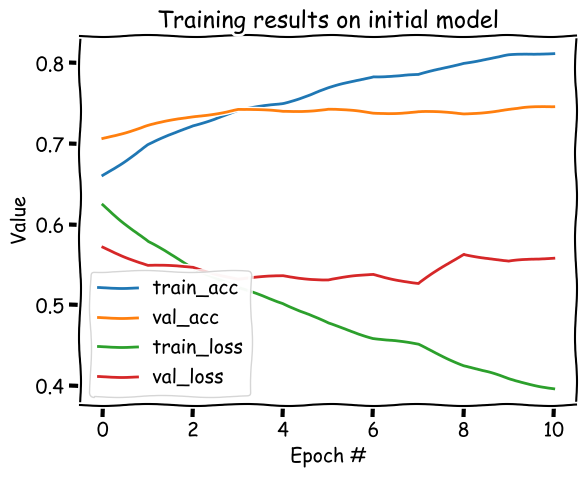

In [112]:
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

with plt.xkcd():
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')



    plt.xlabel('Epoch #')
    plt.ylabel('Value')
    plt.title('Training results on initial model')
    plt.legend()

    plt.show()

In [113]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

61/61 [==============================] - 0s 6ms/step - loss: 0.5279 - accuracy: 0.7680
Test Loss: 0.5278981328010559
Test Accuracy: 0.7679857611656189


In [34]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Predict probabilities for the positive class (class 1)
probabilities = model.predict(X_test, batch_size=BATCH_SIZE)
predicted_classes = (probabilities > 0.5).astype(int)  # Convert probabilities to class labels using 0.5 as the threshold

# If y_test is not a binary array, make sure it is properly formatted as such
# true_classes = y_test if y_test is already a 1D array of labels
# If y_test is one-hot encoded, convert using: true_classes = np.argmax(y_test, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_test, predicted_classes)  # Replace y_test with true_classes if needed

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)


61/61 [==============================] - 1s 4ms/step


ValueError: Classification metrics can't handle a mix of multilabel-indicator and unknown targets

## Hyperparamatertuning

In [9]:
# # Set the random seed for reproducibility
# tf.random.set_seed(42)
# input_length = 20
# num_classes = 1
# EPOCHS=20
# BATCH_SIZE = 32


# def model_build(config, num_classes):
#     input_layer = Input(shape=(20,))
#     embedding = Embedding(input_dim=embeddings_GloVe.shape[0],
#                           output_dim=embeddings_GloVe.shape[1],
#                           weights=[embeddings_GloVe],
#                           trainable=False)(input_layer)
#     spatial_dropout = SpatialDropout1D(0.2)(embedding)
#     conv1d = Conv1D(filters=64, kernel_size=1, activation='relu')(spatial_dropout)

#     conv_dense = Dense(config.dense_units, activation='relu')(conv1d)
#     max_pooling = MaxPooling1D()(conv_dense)
#     lstm = Bidirectional(LSTM(config.lstm_units, activation='tanh', recurrent_activation='sigmoid',
#                               recurrent_dropout=0.2, return_sequences=True))(max_pooling)

#     attention_layer = AdditiveAttention(use_scale=False)
#     attention_output = attention_layer([lstm, lstm], return_attention_scores=False)
#     dense_relu = Dense(config.dense_units, activation='relu')(attention_output)
#     output_layer = Dense(num_classes, activation='sigmoid')(dense_relu)

#     model = Model(inputs=input_layer, outputs=output_layer)
#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#     return model

# sweep_config = {
#     'method': 'bayes',  # Bayesian optimization
#     'metric': {
#         'name': 'val_accuracy',
#         'goal': 'maximize'
#     },
#     'parameters': {
#         'dense_units': {
#             'distribution': 'int_uniform',
#             'min': 95,  # Minimum number of units
#             'max': 105  # Maximum number of units
#         },
#         'lstm_units': {
#             'distribution': 'int_uniform',
#             'min': 58,  # Minimum number of units
#             'max': 68  # Maximum number of units
#         },
#         'lstm_units': {
#             'distribution': 'int_uniform',
#             'min': 74,  # Minimum number of units
#             'max': 84  # Maximum number of units
#         }
#     }
# }

# def train():
#     # Initialize a new wandb run
#     wandb.init()
    
#     # Build model with the current sweep parameters
#     model = model_build(wandb.config, num_classes=1)

#     # Configure WandbCallback to reduce output
#     wandb_callback = WandbCallback(
#     # monitor='val_accuracy',
#     # log_weights=False,  # Do not log model weights
#     # log_gradients=True,  # Do not log gradients
#     # save_model=False,  # Do not save model checkpoints to W&B
#     # training_data=(X_train, y_train),
#     # verbose=0  # Reduce verbosity
# )

    
#     # Train the model
#     model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[early_stopping_callback, wandb_callback])


#     # Cleanup and close wandb run
#     wandb.run.finish()

# # Initialize the sweep
# sweep_id = wandb.sweep(sweep_config, project='Nytt_forsøk')

# # Run the sweep
# wandb.agent(sweep_id, train, count=25)

In [10]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test)
print(f"Test Accuracy: {accuracy:.2f}")

61/61 [==============================] - 1s 3ms/step - loss: 0.0200 - accuracy: 0.0000e+00
Test Accuracy: 0.00


## With POS features

In [11]:
best_model.save(r'C:\Users\bugat\Prosjekter\Tekstanalyse\git_NLP\Tekstanalyse\models\Beast_model')

NameError: name 'best_model' is not defined